In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [2]:
#load the center coordinates (downloaded from CC Google Drive)
centers = pd.read_csv('./kmeans_14clusters_centers.txt',delim_whitespace=True)

#load the PCA projections (Projected using the supervised PCA workflow)
projections = pd.read_csv('./projections_alt.txt',delim_whitespace=True)

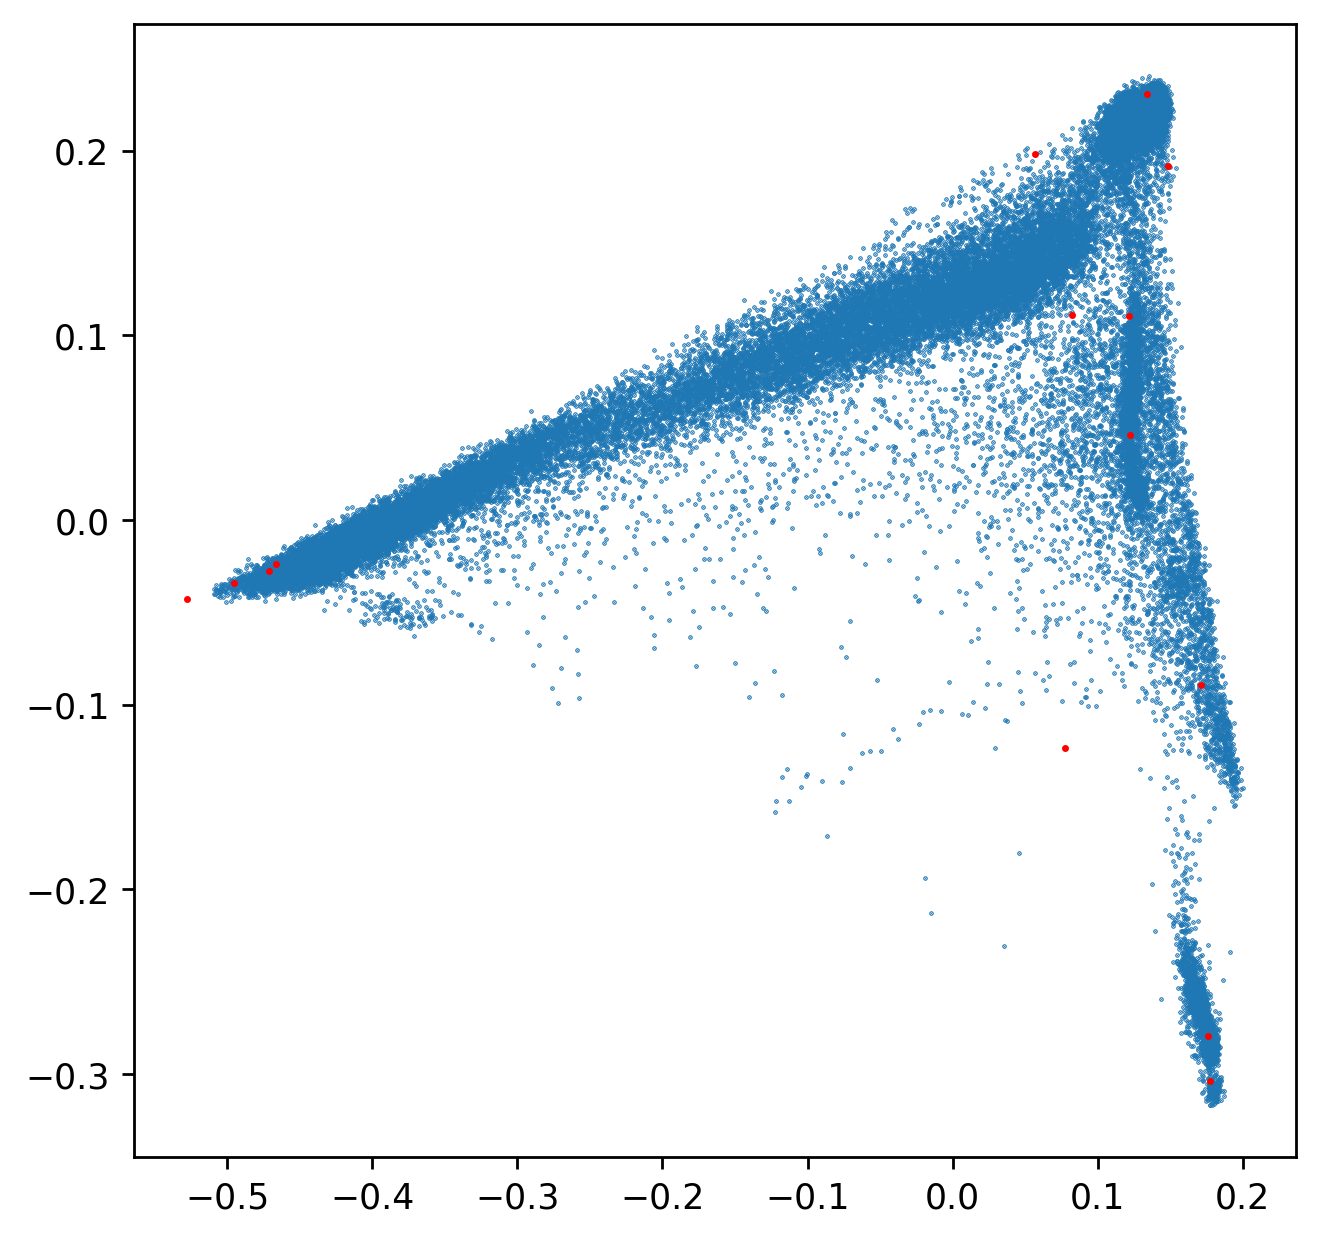

In [3]:
# Plot the projections along with the centers
fig,ax = plt.subplots(figsize=(6,6),dpi=250)
ax.scatter(projections['PC1'],projections['PC2'],s=0.1)
ax.scatter(centers['PC1'],centers['PC2'],s=1,color='red')

In [4]:
#Function to assign the clusters to prjections based on the centroids
def assign_cluster(row, centroids):
    distances = np.sqrt(((centroids - row) ** 2).sum(axis=1))
    return np.argmin(distances) + 1  # +1 for 1-based indexing


In [5]:
projections['cls'] = projections.apply(lambda row: assign_cluster(row.values[2:],centers),axis=1)

In [6]:
#Save and load the projection dataframe, along with their assigned clusters (takes a 1-2 minutes to do clustering each time)
# projections.to_csv('./projections_alt_df.txt',index=None)
# projections = pd.read_csv('./projections_alt_df.txt')

In [9]:
import numpy as np

def calculate_within_between_sums_df(dataframe, centroids, cluster_col='cls'):
    """
    Adopted from the R script shared by the CC. Desribing the details here in case 
    projection/clustering was done using alternatives
    Calculates the total within-cluster sum of squares (tot.withinss) and 
    total between-cluster sum of squares (betweenss) for a DataFrame.
    
    Parameters:
    - dataframe: Pandas DataFrame containing data points and cluster assignments.
    - centroids: A numpy array of cluster centroids (rows are clusters, columns are features).
    - cluster_col: The column name in the DataFrame that holds cluster assignments.

    Returns:
    - tot_withinss: Total within-cluster sum of squares.
    - tot_betweenss: Total between-cluster sum of squares.
    """
    # Extract features and cluster assignments
    feature_columns = dataframe.columns.difference([cluster_col,'FID','IID'])  # Select all columns except 'cls'
    features = dataframe[feature_columns].values  # Feature matrix as NumPy array
    cluster_assignments = dataframe[cluster_col].values  # Cluster assignments

    # Calculate overall data mean
    global_mean = features.mean(axis=0)

    # Initialize sums
    tot_withinss = 0.0
    tot_betweenss = 0.0
    centroids = centroids.values
    # Iterate over each cluster
    for k in range(centroids.shape[0]):  # Number of clusters
        # Get points in the current cluster
        cluster_points = features[cluster_assignments == k + 1]  # +1 to match 1-based indexing

        # Within-cluster sum of squares
        tot_withinss += ((cluster_points - centroids[k]) ** 2).sum()

        # Between-cluster sum of squares
        n_k = len(cluster_points)  # Number of points in the cluster
        tot_betweenss += n_k * np.sum((centroids[k] - global_mean) ** 2)

    return tot_withinss, tot_betweenss



In [10]:
# Usage
# Assuming `cls` as the cluster assignments
# Remember from above that the `centers` is a NumPy array of cluster centroids.

tot_withinss, tot_betweenss = calculate_within_between_sums_df(projections, centers, cluster_col='cls')

# Compute the ratio
within_between_ratio = tot_withinss / tot_betweenss
print(f"Total Within-Cluster Sum of Squares: {tot_withinss}")
print(f"Total Between-Cluster Sum of Squares: {tot_betweenss}")
print(f"Within/Between Ratio: {within_between_ratio}")


Total Within-Cluster Sum of Squares: 4620.193907582103
Total Between-Cluster Sum of Squares: 6394.613480966783
Within/Between Ratio: 0.7225133968352985


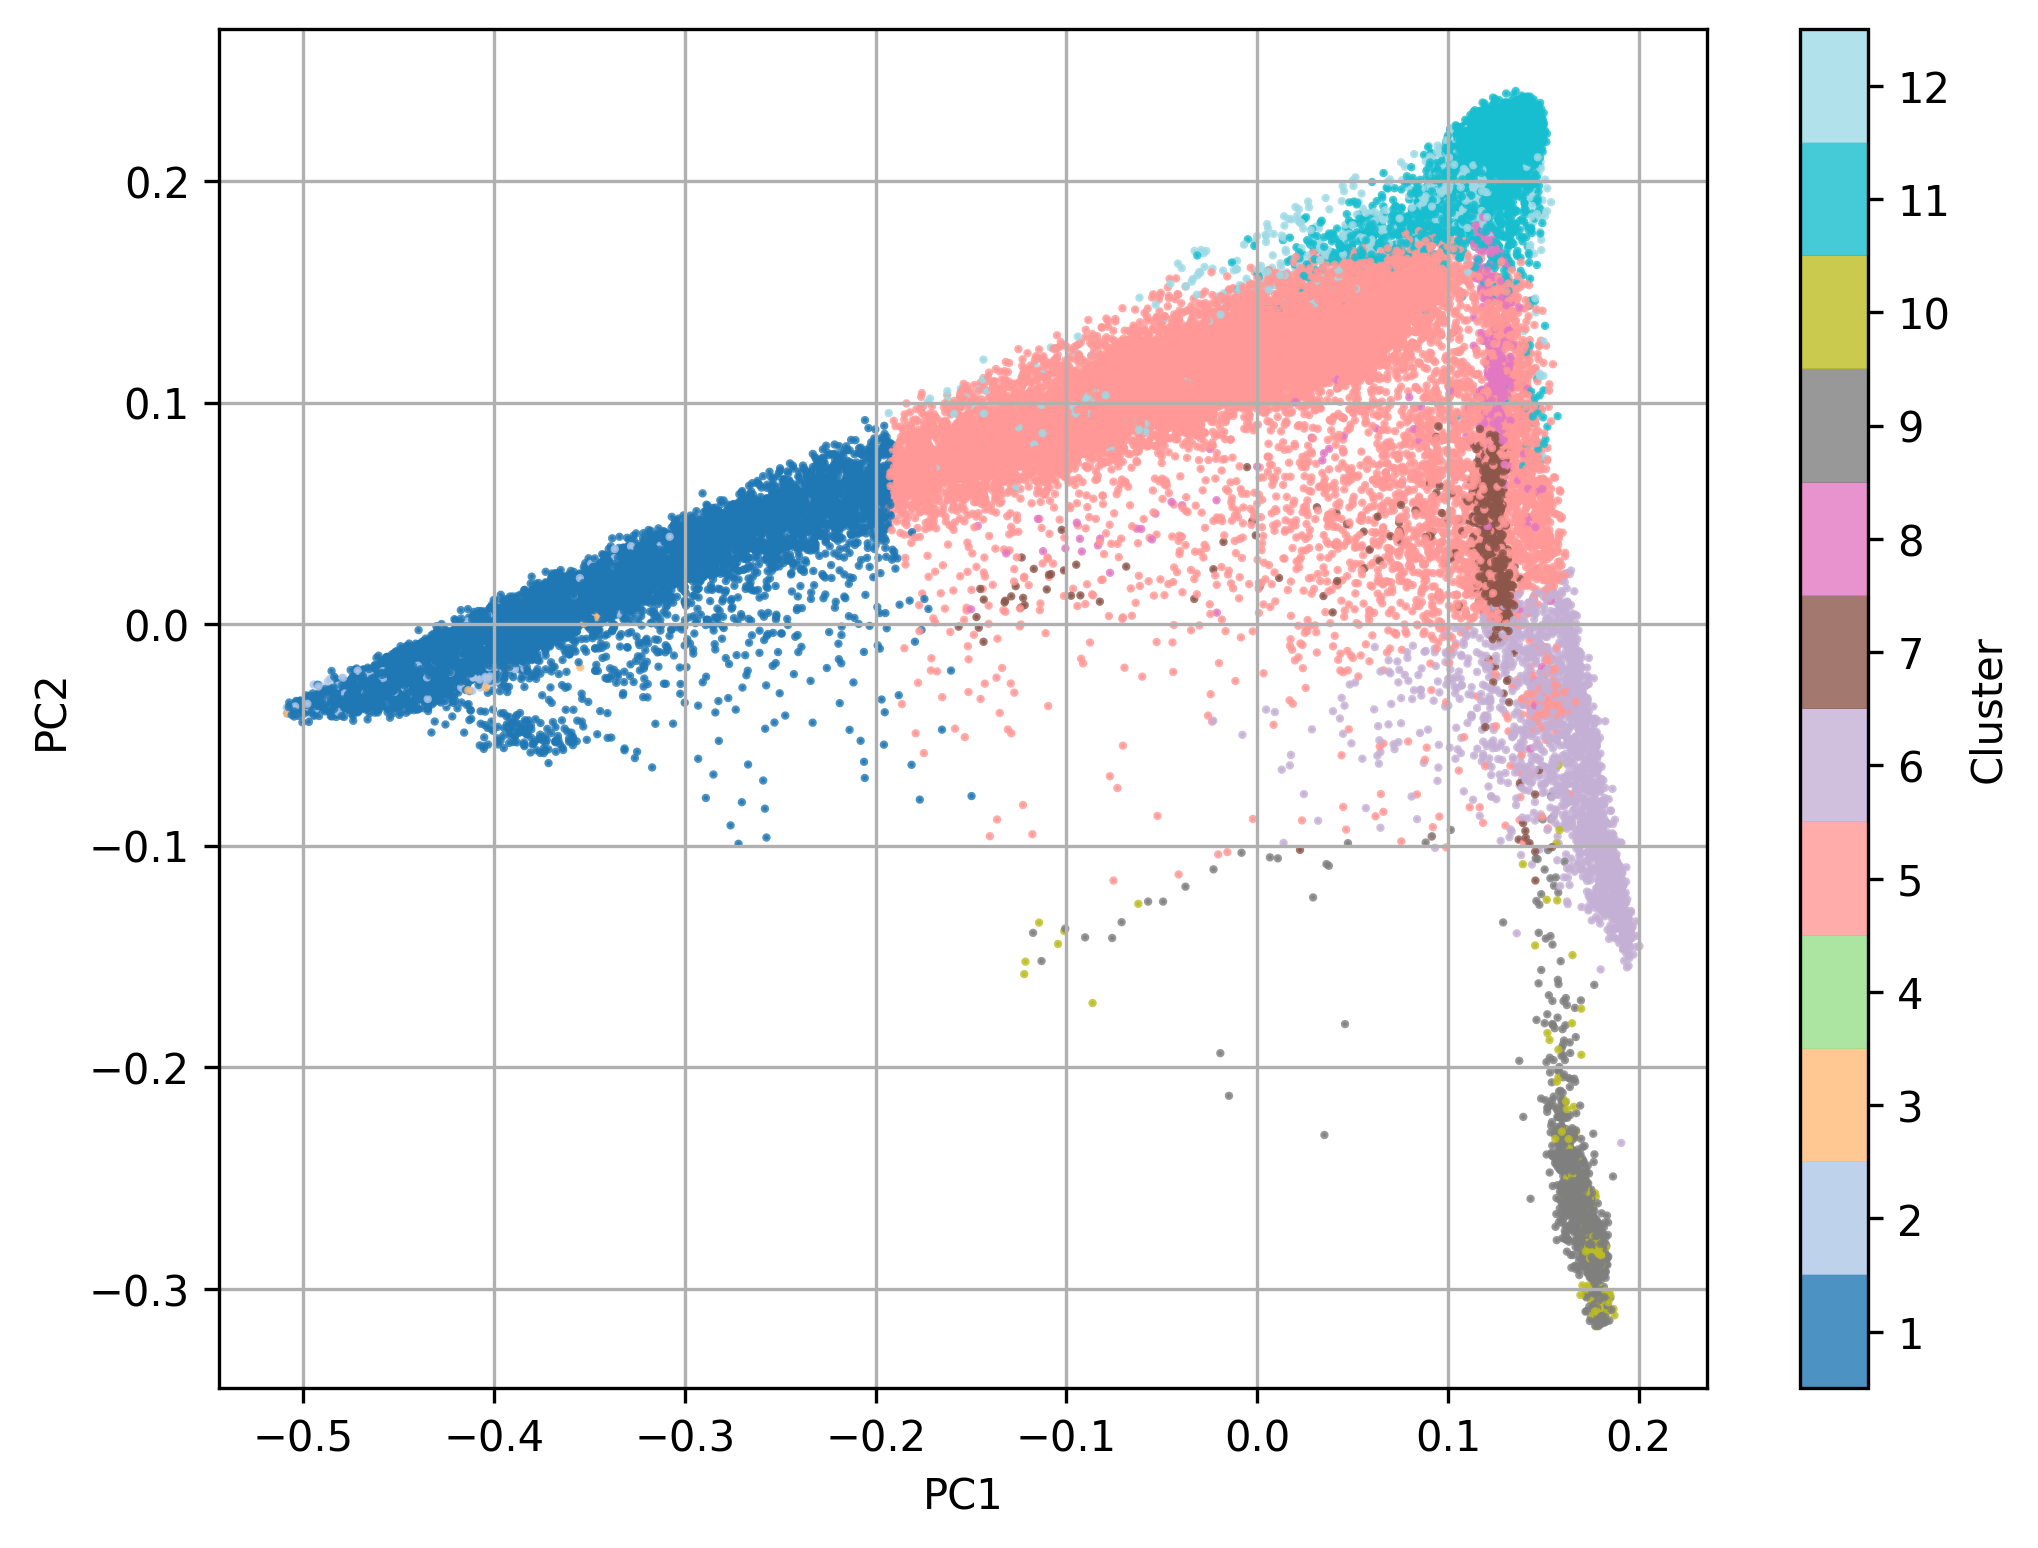

In [11]:
#Plot the projections, this time colorted by the cluster assignments
fig, ax = plt.subplots(figsize=(8, 6),dpi=300)

colors = plt.cm.tab20(np.linspace(0, 1, 12))
custom_cmap = ListedColormap(colors)
# Scatter plot of the first two PCs colored by cluster
scatter = ax.scatter(
    projections['PC1'], projections['PC2'], c=projections['cls'], cmap=custom_cmap, s=1, alpha=0.8
)

# Add a colorbar to the figure
cbar = fig.colorbar(scatter, ax=ax, label='Cluster')

num_clusters = projections['cls'].nunique()
ticks = np.arange(1, num_clusters + 1)+0.5  # Cluster labels
cbar.set_ticks(ticks)
cbar.set_ticklabels([int(item) for item in ticks-0.5])

# Add labels, title, and grid
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
# ax.set_title('Clustering Based on First Two Principal Components')
ax.grid(True)

In [12]:
#Loading orthogonal information on groupings in the cohort
ethnicity = pd.read_csv('/addr/to/file/containing/questionaire_ethnicity.tsv',delimiter='\t')

#Merge the DFs containing orthogonal info with the one containing the projections and clustering information
ethnicity.set_index('pid',inplace=True)
projections.set_index('IID',inplace=True)
mdf = ethnicity.join(projections,how='inner')
#remove NAs
mdf.dropna(axis=0,subset=['ethnicity'],inplace=True)

#Get the total count of each cluster/ethcnicity pair
gdf = mdf.groupby(['cls','ethnicity']).size().reset_index(name='count')
#Calculate proportion of each ethcnicity within each cluster
gdf['proportion'] = gdf.groupby('cls')['count'].transform(lambda x: x/x.sum())

/sc/arion/projects/kennylab/roohy/conda/envs/nukbb/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.0, 'Ancestry Distribution by Cluster')

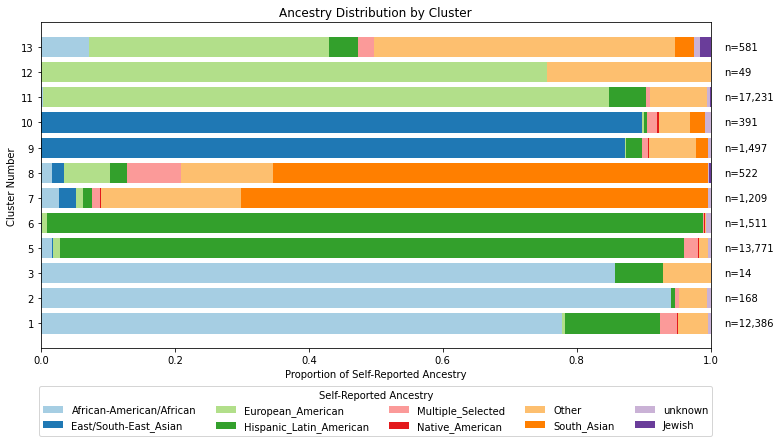

In [18]:
#Plot the proportions
grouped_df = gdf.sort_values(['cls', 'ethnicity'])
cls_list = grouped_df['cls'].unique()
eth_list = grouped_df['ethnicity'].unique()
cls_names = [str(item) for item in cls_list]

palette = sns.color_palette("Paired", n_colors=len(eth_list)) #spectral

total_counts = []


# Compute total counts for each cluster
for item in cls_list:
    total_count = grouped_df[grouped_df['cls'] == item]['count'].sum()
    total_counts.append(total_count)


fig, ax = plt.subplots(figsize=(12, 6))

# Initialize a variable to keep track of the bottom of each bar

bottom = np.zeros(len(cls_list))
# Iterate over each cluster

for eth,color in zip(eth_list,palette):
    values = np.zeros(bottom.shape[0])
    for index,item in enumerate(cls_list):
        
        query_res = grouped_df[(grouped_df['cls']==item)&(grouped_df['ethnicity']==eth)]
        if query_res.empty:
            values[index]= 0
        else:
            values[index] = query_res['proportion'].values[0]
    ax.barh(cls_names,values,left=bottom,label=eth,color=color)
    bottom += values


for i, total in enumerate(total_counts):
    ax.text(
        1.02,  
        i,    
        f"n={total:,}",  
        va="center",
        ha="left",
        fontsize=10,
        transform=ax.get_yaxis_transform()
    )


legend = ax.legend(title='Self-Reported Ancestry', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=5)
    
ax.set_xlabel('Proportion of Self-Reported Ancestry')
ax.set_ylabel('Cluster Number')
ax.set_title('Ancestry Distribution by Cluster')
